In [28]:
# imports
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rn
import sklearn
from sklearn import metrics
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1) Data preparation

read csv files into pandas datafram and allocate corresponding sentiment value to each phrase

In [29]:
# Load in the dictionary dataset into a pandas df
folder = '/kaggle/input/stanford-sentiment-treebank/stanfordSentimentTreebank/'
data_path = os.path.join(os.getcwd(), folder, 'dictionary.txt')
dic = pd.read_csv(data_path, sep='|', header=None)

# ...and do the same with the sentiment_labels data
data_path = os.path.join(os.getcwd(), folder, 'sentiment_labels.txt')
cents = pd.read_csv(data_path, sep='|')

dic = dic.rename(columns={0: "phrase", 1: "ID"}) # rename the columns
dic = dic.sort_values(by="ID") # change the order of the rows to be sorted by ID number

#make an array of the sentiments (already in the right order) and add it to our df
y = np.array(cents.iloc[:, -1])
dic.insert(2, "sentiment", y)

phrase_data = dic.sort_index()
phrase_data.drop("ID",axis=1,inplace=True) # remove redundant information
phrase_data.insert(2,"label",0)

print(phrase_data.head()) #check
print(phrase_data.shape)

        phrase  sentiment  label
0            !    0.50000      0
1          ! '    0.52778      0
2         ! ''    0.50000      0
3       ! Alas    0.44444      0
4  ! Brilliant    0.86111      0
(239232, 3)


as this is a multiclass classification problem the sentiment values must be assigned a sentiment label:

0-0.2 -> very negative -> label:0

0.2-0.4 -> negative -> label:1

0.4-0.6 -> neutral -> label:2

0.6-0.8 -> positive -> label:3

0.8-1 -> very positive -> label:4

this can be done with numpy masking



In [30]:
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
np_phrase = np.array(phrase_data) # convert dataframe to numpy

vpos = (0.8 < np_phrase[:, 1]).astype(int) # map sentiment value to label
pos =  (0.6 < np_phrase[:, 1]).astype(int)
ntrl = (0.4 < np_phrase[:, 1]).astype(int)
neg = (0.2 < np_phrase[:, 1]).astype(int)
vneg = (0 <= np_phrase[:, 1]).astype(int)

h = vneg + neg + ntrl + pos + vpos - 1

np_phrase[:, 2] = h


phrase_data = pd.DataFrame(np_phrase) # convert back to dataframe
print(phrase_data.head()) #check data
print(phrase_data.shape)


             0        1  2
0            !      0.5  2
1          ! '  0.52778  2
2         ! ''      0.5  2
3       ! Alas  0.44444  2
4  ! Brilliant  0.86111  4
(239232, 3)


now the data must be 'cleaned' - ie remove numbers, punctuation and filler word
the data must also be tokenised to create encodings

In [31]:
filler_words = list(stopwords.words('english'))+['movie','films','film','movies','review'] #set of english filler words from nltk library and other words to exclude
to_drop =[]

for i in range(phrase_data.shape[0]):
    phrase = phrase_data.loc[i, 0]
    cleaned = re.sub(r'[^\w]', " ", phrase) #remove all special characters 
    cleaned = re.sub(r'[\d]', " ", cleaned)  #remove all numbers 
    if (cleaned.replace(" ","")==""): # if nothing left, record index to remove from dataset
        to_drop.append(i)
        cleaned=""
    else:
        cleaned = word_tokenize(cleaned.lower()) #convert to lowercase and tokenise each word
        cleaned = [w for w in cleaned if w not in filler_words] #remove all filler words from phrase
    phrase_data.loc[i, 0] = cleaned 

# remove redundant data
phrase_data.drop(to_drop,axis=0,inplace=True) #drop empty entries
cleaned_phrases = phrase_data[~phrase_data.astype(str).duplicated()] # drop duplicated entries 
cleaned_phrases.reset_index(inplace=True)
cleaned_phrases.drop("index",axis=1,inplace=True)
cleaned_phrases = cleaned_phrases.rename(columns={0: "phrase", 1: "sentiment", 2: "label"})
print(cleaned_phrases.head())
print(cleaned_phrases.shape)

cleaned_phrases.to_pickle("clean_data.pkl")

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


        phrase sentiment label
0       [alas]   0.44444     2
1  [brilliant]   0.86111     4
2  [brilliant]   0.93056     4
3  [brilliant]       1.0     4
4     [c, mon]   0.47222     2
(211000, 3)


# 2) Encoding

we will be comparing the effectiveness of dense and convoluted networks on sparse matrix encodings in this project

In [18]:
X = cleaned_phrases["phrase"].copy() # features
y = cleaned_phrases["label"].copy() #labels


#create word vector 
vectorizer = CountVectorizer()
vectorizerfit = vectorizer.fit_transform(X.astype(str))
names = vectorizer.get_feature_names()
count_array = vectorizerfit.toarray()
vec_sparse = pd.DataFrame(data=count_array,columns=names)
#print(vec_sparse)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 3) Exploratory Data Analysis

## overall analysis

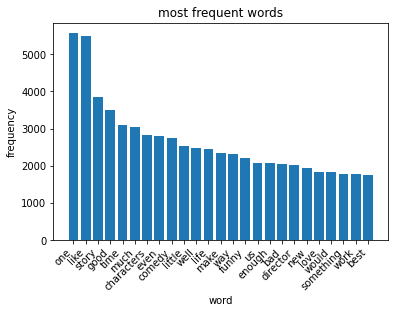

In [19]:
#most frequent words

freqwords = vec_sparse.sum(axis=0)
freqwords=freqwords.sort_values(ascending=False)

#top25
y=freqwords[:25]
x=freqwords.keys()[:25]

ax= plt.subplot()
plt.bar(x,y)
plt.title("most frequent words")
plt.xlabel("word")
plt.ylabel("frequency")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()


In [20]:
#average sentiment, average tokenised phrase length
mean_sent = cleaned_phrases["sentiment"].mean()
print("the mean sentiment value of the dataset is: " +str(mean_sent) + " which corresponds to label: " + str(labels[int(np.round(mean_sent*5)-1)]) )

mean_len=cleaned_phrases["phrase"].str.len().mean()
print("the mean cleaned tokenised phrase length of the dataset is: " +str(mean_len))

the mean sentiment value of the dataset is: 0.5134870089621033 which corresponds to label: neutral
the mean cleaned tokenised phrase length of the dataset is: 4.400345971563981


## analysis by sentiment

In [21]:
sentiment_groups = cleaned_phrases.groupby('label')
vneg_group= sentiment_groups.get_group(0)
neg_group= sentiment_groups.get_group(1)
neu_group= sentiment_groups.get_group(2)
pos_group= sentiment_groups.get_group(3)
vpos_group= sentiment_groups.get_group(4)

In [22]:
#analysis of each sentiment

num =[]
lengths=[]
sent =[]
freqword_count =[]
freqword_label =[]


for j in [vneg_group, neg_group, neu_group, pos_group, vpos_group]:
    num.append(j.shape[0])
    lengths.append(j["phrase"].str.len().mean())
    sent.append(j["sentiment"].mean())
    
    X_sent = j["phrase"].copy() # features
    
    vectorizer = CountVectorizer()
    vectorizerfit = vectorizer.fit_transform(X_sent.astype(str))
    names = vectorizer.get_feature_names()
    count_array = vectorizerfit.toarray()
    vec_sent = pd.DataFrame(data=count_array,columns=names)

    freqwords = vec_sent.sum(axis=0)
    freqwords=freqwords.sort_values(ascending=False)

    #top 10
    freqword_count.append(freqwords[:10])
    freqword_label.append(freqwords.keys()[:10])
    



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


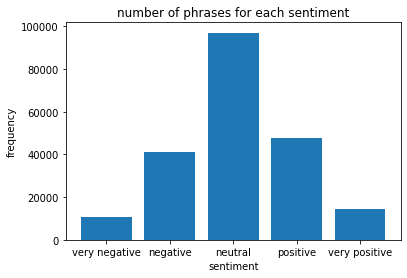

In [23]:
#number of reviews per sentiment
ax= plt.subplot()
plt.bar(labels,num)
plt.title("number of phrases for each sentiment")
plt.xlabel("sentiment")
plt.ylabel("frequency")
plt.show()

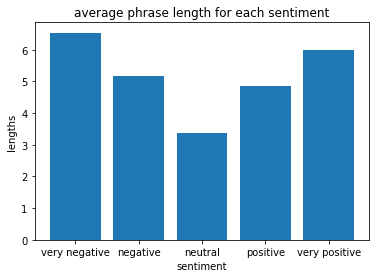

In [24]:
#average phrase lengths of each sentiment
ax= plt.subplot()
plt.bar(labels,lengths)
plt.title("average phrase length for each sentiment")
plt.xlabel("sentiment")
plt.ylabel("lengths")
plt.show()


In [25]:
for k in range (len(sent)):
    print("the mean sentiment value of the " +str(labels[k])+ " dataset is: " +str(sent[k]))

the mean sentiment value of the very negative dataset is: 0.13906200046070263
the mean sentiment value of the negative dataset is: 0.31068579101062604
the mean sentiment value of the neutral dataset is: 0.5030924660950524
the mean sentiment value of the positive dataset is: 0.6908042537344863
the mean sentiment value of the very positive dataset is: 0.8570886989232243


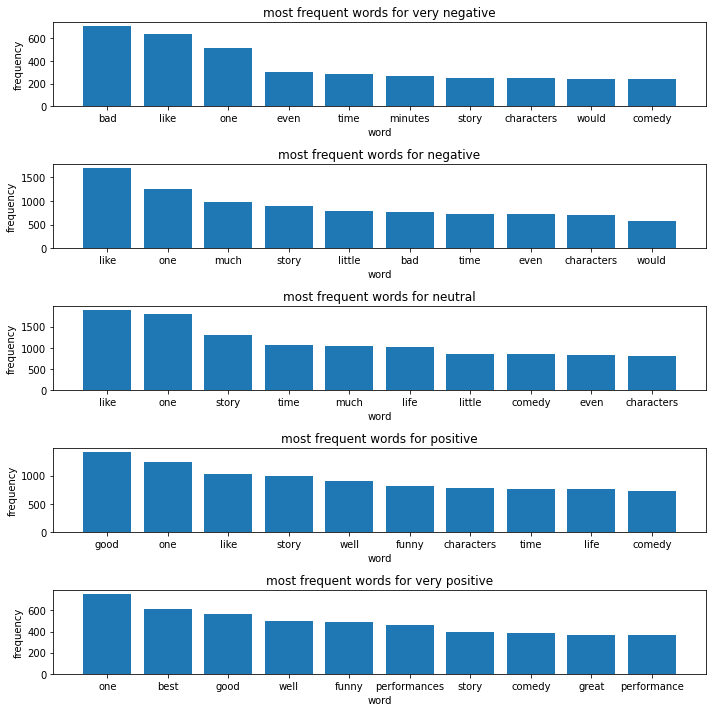

In [26]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.bar(freqword_label[i],freqword_count[i])
    plt.title("most frequent words for " + str(labels[i]))
    plt.xlabel("word")
    plt.ylabel("frequency")
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


key comments:
- there is a disproporitonate amount of neutral reviews in the dataset - this is likely to cause a bias towards neutral within out models.
- there is a significant lack of very positive and very negative reviews - this is likely to result in the model having difficulty to classify extreme sentiment
- the overall most frequent words were 'one', 'like' and 'story' - however these words also frequently appeared accross all sentiments suggesting that they have little variance when weighted for classification
- the neutral phrases had the shortest average length in comparison to the other sentiments